# 1. Import Libraries

In [43]:
# !pip install -U sentence-transformers 
# !pip install tf-keras
# !pip install openai==0.28.1
# !pip install wordcloud
# !pip install xgboost
# !pip install mlflow

In [44]:
import pandas as pd
from collections import Counter
import sys
import os
import ast
from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt

from new_or_used import build_dataset

pd.set_option('display.max_columns', None)



# 2. Load Data

In [45]:
X_train_raw, y_train, X_test_raw, y_test = build_dataset()
X_train_raw = pd.json_normalize(X_train_raw)
X_test_raw = pd.json_normalize(X_test_raw)

X_train = X_train_raw.copy()
X_test = X_test_raw.copy()

In [46]:
X_train.drop(columns=['pictures'], inplace=True)
X_test.drop(columns=['pictures'], inplace=True)

In [47]:
print(X_train.shape)
X_train.head()

(90000, 55)


,warranty,sub_status,condition,deal_ids,base_price,non_mercado_pago_payment_methods,seller_id,variations,site_id,listing_type_id,price,attributes,buying_mode,tags,listing_source,parent_item_id,coverage_areas,category_id,descriptions,last_updated,international_delivery_mode,id,official_store_id,differential_pricing,accepts_mercadopago,original_price,currency_id,thumbnail,title,automatic_relist,date_created,secure_thumbnail,stop_time,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,sold_quantity,available_quantity,seller_address.country.name,seller_address.country.id,seller_address.state.name,seller_address.state.id,seller_address.city.name,seller_address.city.id,shipping.local_pick_up,shipping.methods,shipping.tags,shipping.free_shipping,shipping.mode,shipping.dimensions,shipping.free_methods
0,None,[],new,[],80.0,"[{'description': 'Transferencia bancaria', 'id...",8208882349,[],MLA,bronze,80.0,[],buy_it_now,[dragged_bids_and_visits],,MLA6553902747,[],MLA126406,[{'id': 'MLA4695330653-912855983'}],2015-09-05T20:42:58.000Z,none,MLA4695330653,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/5386-MLA469533065...,Auriculares Samsung Originales Manos Libres Ca...,False,2015-09-05T20:42:53.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1446669773000,active,None,NaN,None,1,1441485773000,http://articulo.mercadolibre.com.ar/MLA4695330...,0,1,Argentina,AR,Capital Federal,AR-C,San Cristóbal,TUxBQlNBTjkwNTZa,True,[],[],False,not_specified,None,NaN
1,NUESTRA REPUTACION,[],used,[],2650.0,"[{'description': 'Transferencia bancaria', 'id...",8141699488,[],MLA,silver,2650.0,[],buy_it_now,[],,MLA7727150374,[],MLA10267,[{'id': 'MLA7160447179-930764806'}],2015-09-26T18:08:34.000Z,none,MLA7160447179,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/23223-MLA71604471...,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,2015-09-26T18:08:30.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1448474910000,active,None,NaN,None,1,1443290910000,http://articulo.mercadolibre.com.ar/MLA7160447...,0,1,Argentina,AR,Capital Federal,AR-C,Buenos Aires,,True,[],[],False,me2,None,NaN
2,None,[],used,[],60.0,"[{'description': 'Transferencia bancaria', 'id...",8386096505,[],MLA,bronze,60.0,[],buy_it_now,[dragged_bids_and_visits],,MLA6561247998,[],MLA1227,[{'id': 'MLA7367189936-916478256'}],2015-09-09T23:57:10.000Z,none,MLA7367189936,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/22076-MLA73671899...,"Antigua Revista Billiken, N° 1826, Año 1954",False,2015-09-09T23:57:07.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1447027027000,active,None,NaN,None,1,1441843027000,http://articulo.mercadolibre.com.ar/MLA7367189...,0,1,Argentina,AR,Capital Federal,AR-C,Boedo,TUxBQkJPRTQ0OTRa,True,[],[],False,me2,None,NaN
3,None,[],new,[],580.0,"[{'description': 'Transferencia bancaria', 'id...",5377752182,[],MLA,silver,580.0,[],buy_it_now,[],,None,[],MLA86345,[{'id': 'MLA9191625553-932309698'}],2015-10-05T16:03:50.306Z,none,MLA9191625553,NaN,None,True,NaN,ARS,http://mla-s2-p.mlstatic.com/183901-MLA9191625...,Alarma Guardtex Gx412 Seguridad Para El Automo...,False,2015-09-28T18:47:56.000Z,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,1449191596000,active,None,NaN,None,1,1443466076000,http://articulo.mercadolibre.com.ar/MLA9191625...,0,1,Argentina,AR,Capital Federal,AR-C,Floresta,TUxBQkZMTzg5MjFa,True,[],[],False,me2,None,NaN
4,MI REPUTACION.,[],used,[],30.0,"[{'description': 'Transferencia bancaria', 'id...",2938071313,[],MLA,bronze,30.0,[],buy_it_now,[dragged_bids_and_visits],,MLA3133256685,[],MLA41287,[{'id': 'MLA7787961817-902981678'}],2015-08-28T13:37:41.000Z,none,MLA7787961817,NaN,None,True,NaN,ARS,http://mla-s2-p.mlstatic.com/13595-MLA77879618...,Serenata - Jennifer Blake,False,2015-08-24T22:07:20.000Z,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,1445638040000,active,None,NaN,None,1,1440454040000,http://articulo.mercadolibre.com.ar/MLA7787961...,0,1,Argentina,AR,Buenos Aires,AR-B,Tres de febrero,TUxBQ1RSRTMx

In [48]:
print(X_train.dtypes.value_counts())
print(X_train.dtypes)

object     40
int64       6
float64     5
bool        4
Name: count, dtype: int64
warranty                             object
sub_status                           object
condition                            object
deal_ids                             object
base_price                          float64
non_mercado_pago_payment_methods     object
seller_id                             int64
variations                           object
site_id                              object
listing_type_id                      object
price                               float64
attributes                           object
buying_mode                          object
tags                                 object
listing_source                       object
parent_item_id                       object
coverage_areas                       object
category_id                          object
descriptions                         object
last_updated                         object
international_delivery_mode          o

# 3. EDA

## Columns made of dictionaries

In [49]:
# # A partir del diccionario de datos proporcionado, se seleccionan las columnas compuestas por listas de diccionarios
# columns_to_analyze = ['descriptions', 'non_mercado_pago_payment_methods', 'pictures']

In [50]:
# for column in columns_to_analyze:
#     print(f"Column: {column}")
#     print(X_train[column][0])

### Se observa que cada columna a analizar tiene un formato diferente, por lo que se debe aplicar una función diferente a cada una de ellas

#### descriptions

In [51]:
def parse_description(cell):
    if isinstance(cell, list) and len(cell) > 0:
        try:
            return ast.literal_eval(cell[0])
        except:
            return None
    return None

In [52]:
X_train['descriptions'] = X_train['descriptions'].apply(parse_description)
X_train['description_id'] = X_train['descriptions'].apply(lambda x: x.get('id') if isinstance(x, dict) else None)
X_train.drop(columns=['descriptions'], inplace=True)


#### non_mercado_pago_payment_methods

In [53]:
# Se revisan si los Ids de cada metodo de pago son únicos
payment_rows = []

for row in X_train['non_mercado_pago_payment_methods']:
    if isinstance(row, list):
        for item in row:
            if isinstance(item, dict):
                payment_rows.append(item)

# Crear un DataFrame con todas las entradas individuales
payment_df = pd.DataFrame(payment_rows)

# Ver los valores únicos de 'id' y 'type' para cada 'description'
unique_combos = payment_df.groupby('description')[['id', 'type']].nunique()

print(unique_combos)

                          id  type
description                       
Acordar con el comprador   1     1
American Express           1     1
Cheque certificado         1     1
Contra reembolso           1     1
Diners                     1     1
Efectivo                   1     1
Giro postal                1     1
MasterCard                 1     1
Mastercard Maestro         1     1
MercadoPago                1     1
Tarjeta de crédito         1     1
Transferencia bancaria     1     1
Visa                       1     1
Visa Electron              1     1


In [54]:
# Extraemos solo las 'description' de cada fila
X_train['payment_descriptions'] = X_train['non_mercado_pago_payment_methods'].apply(
    lambda lst: [d['description'] for d in lst] if isinstance(lst, list) else []
)

mlb = MultiLabelBinarizer()

# Ajustar y transformar
payment_dummies = pd.DataFrame(
    mlb.fit_transform(X_train['payment_descriptions']),
    columns=[f"non_mercado_pago_payment_methods_description_{desc}" for desc in mlb.classes_],
    index=X_train.index
)

X_train = pd.concat([X_train, payment_dummies], axis=1)
X_train.drop(columns=['non_mercado_pago_payment_methods'], inplace=True)


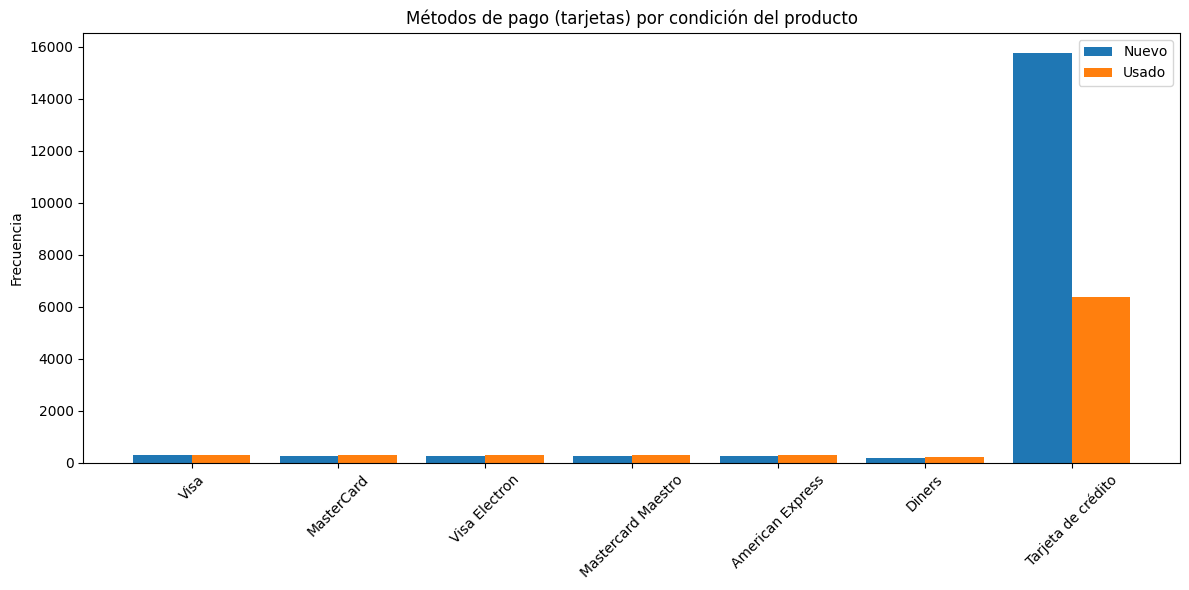

In [55]:
# Lista de métodos relacionados con tarjetas
tarjetas = [
    "Visa", "MasterCard", "Visa Electron", "Mastercard Maestro",
    "American Express", "Diners", "Tarjeta de crédito"
]

# Columnas existentes en tu DataFrame
tarjetas_cols = [
    f"non_mercado_pago_payment_methods_description_{t}"
    for t in tarjetas
    if f"non_mercado_pago_payment_methods_description_{t}" in X_train.columns
]

# Contar cuántas veces se usa cada método según condición
data = {"method": [], "new": [], "used": []}
for col in tarjetas_cols:
    metodo = col.replace("non_mercado_pago_payment_methods_description_", "")
    data["method"].append(metodo)
    data["new"].append(X_train[X_train["condition"] == "new"][col].sum())
    data["used"].append(X_train[X_train["condition"] == "used"][col].sum())

# Crear gráfico
x = range(len(data["method"]))
plt.figure(figsize=(12, 6))
plt.bar([i - 0.2 for i in x], data["new"], width=0.4, label="Nuevo")
plt.bar([i + 0.2 for i in x], data["used"], width=0.4, label="Usado")
plt.xticks(ticks=x, labels=data["method"], rotation=45)
plt.ylabel("Frecuencia")
plt.title("Métodos de pago (tarjetas) por condición del producto")
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
tarjetas = [
    "Visa", "MasterCard", "Visa Electron", "Mastercard Maestro",
    "American Express", "Diners", "Tarjeta de crédito"
]

# Columnas existentes en tu DataFrame
tarjetas_cols = [
    f"non_mercado_pago_payment_methods_description_{t}"
    for t in tarjetas
    if f"non_mercado_pago_payment_methods_description_{t}" in X_train.columns
]

# Crear una nueva columna binaria que indica si se usó alguna tarjeta
X_train["payment_method_Tarjeta"] = X_train[tarjetas_cols].sum(axis=1).clip(upper=1)

# Opcional: eliminar las columnas individuales de tarjetas
X_train.drop(columns=tarjetas_cols, inplace=True)

In [57]:
# Comprobar que los métodos de pago son mutuamente excluyentes


payment_matrix = pd.DataFrame(
    mlb.fit_transform(X_train['payment_descriptions']),
    columns=mlb.classes_,
    index=X_train.index
)


pairs = []
columns = payment_matrix.columns

for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if (payment_matrix[col1] == payment_matrix[col2]).all():
            pairs.append((col1, col2))

print("Métodos de pago que siempre aparecen juntos:")
for p in pairs:
    print(f"- {p[0]}  <-->  {p[1]}")

Métodos de pago que siempre aparecen juntos:


## NaNs in columns made of lists

#### ["sub_status", "variations", "deal_ids", "attributes", "coverage_areas"]

In [ ]:
columnas_con_listas = ["sub_status", "variations", "deal_ids", "attributes", "coverage_areas", 'shipping.methods', 'shipping.tags']


for columna in columnas_con_listas:
    print(f"===== {columna.upper()} =====")

    # Marcar si tiene datos
    X_train[f'has_{columna}'] = X_train[columna].apply(lambda x: isinstance(x, list) and len(x) > 0)

    # Contar vacíos vs no vacíos
    counts = X_train[f'has_{columna}'].value_counts()
    print(f"Filas {columna} vacías: {counts.get(False, 0)}")
    print(f"Filas {columna} NO vacías: {counts.get(True, 0)}")
    print(f"Porcentaje de filas {columna} vacías: {counts.get(False, 0) / len(X_train) * 100:.2f}%")

    # Cruzar con condición
    print("\nDistribución por condición:")
    crosstab = pd.crosstab(X_train[f'has_{columna}'], X_train['condition'])
    print(crosstab)

    print("\nPorcentajes por fila:")
    print(crosstab.div(crosstab.sum(axis=1), axis=0).round(3))
    print("\n\n")

===== SUB_STATUS =====
Filas sub_status vacías: 89109
Filas sub_status NO vacías: 891
Porcentaje de filas sub_status vacías: 99.01%

Distribución por condición:
condition         new   used
has_sub_status              
False           47859  41250
True              493    398

Porcentajes por fila:
condition         new   used
has_sub_status              
False           0.537  0.463
True            0.553  0.447



===== VARIATIONS =====
Filas variations vacías: 82626
Filas variations NO vacías: 7374
Porcentaje de filas variations vacías: 91.81%

Distribución por condición:
condition         new   used
has_variations              
False           44112  38514
True             4240   3134

Porcentajes por fila:
condition         new   used
has_variations              
False           0.534  0.466
True            0.575  0.425



===== DEAL_IDS =====
Filas deal_ids vacías: 89783
Filas deal_ids NO vacías: 217
Porcentaje de filas deal_ids vacías: 99.76%

Distribución por condición:
conditio

| Columna           | % Vacíos | Diferencia en `condition` (`has=True`) | Paso a seguir | 
|------------------|----------|-----------------------------------------|---------------|
| `sub_status`     | 99.01%   | No significativa (55.3% new / 44.7% used) |  Eliminar | 
| `variations`     | 91.81%   | Ligera tendencia a `new` (57.5%)         |  Se transformara el dato binario y se llamara "has_variations" | 
| `deal_ids`       | 99.76%   | Fuerte asociación con `new` (98.2%)      |  Eliminar | 
| `attributes`     | 87.61%   | Moderada tendencia a `new` (59.9%)       |  Se transformara el dato binario y se llamara "has_attributes" | 
| `coverage_areas` | 100%     | No hay datos                             | Eliminar | 
| `shipping.tags`  | 99.93%   | No hay datos                             | Eliminar | 
| `shipping.methods` | 100%     | No hay datos                             | Eliminar | 

In [59]:
# Transformar listas en columnas binarias
X_train['has_variations'] = X_train['variations'].apply(lambda x: isinstance(x, list) and len(x) > 0)
X_train['has_attributes'] = X_train['attributes'].apply(lambda x: isinstance(x, list) and len(x) > 0)

# Eliminar columnas que no aportan o están completamente vacías
X_train.drop(columns=['sub_status', 'coverage_areas', 'variations', 'deal_ids', 'attributes', 'payment_descriptions', 'shipping.methods', 'shipping.tags'], inplace=True)

#### Tags

In [60]:
# Calcular longitud de cada lista
tag_lengths = X_train['tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Porcentaje de listas vacías
empty_pct = (tag_lengths == 0).mean() * 100

# Porcentaje de listas no vacías
non_empty_pct = (tag_lengths > 0).mean() * 100

print(f"Porcentaje de filas con tags vacíos: {empty_pct:.2f}%")
print(f"Porcentaje de filas con tags no vacíos: {non_empty_pct:.2f}%")

Porcentaje de filas con tags vacíos: 24.90%
Porcentaje de filas con tags no vacíos: 75.10%


#### A partir del analisis, se realizara un MultiLabelBinarizer en la columna tags

In [61]:
# Asegurar que sean listas válidas
tags_list = X_train['tags'].apply(lambda x: x if isinstance(x, list) else [])

mlb = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(
    mlb.fit_transform(tags_list),
    columns=[f'tag_{t}' for t in mlb.classes_],
    index=X_train.index
)

X_train = pd.concat([X_train, tags_encoded], axis=1)
X_train.drop(columns=['tags'], inplace=True)

## Columnas con NaNs

### Se hizo una revision y se encontró que hay combinacion entre np.nan, None, none y '', por lo que se deciden estandarizar en np.nan

In [62]:
import numpy as np

# Reemplazar string 'none' (case-insensitive) por np.nan
X_train.replace(to_replace='none', value=np.nan, inplace=True)
X_train.replace(to_replace='None', value=np.nan, inplace=True)
X_train.replace("", np.nan, inplace=True)

# También convertir valores None explícitos a np.nan si hace falta
X_train = X_train.applymap(lambda x: np.nan if x is None else x)

/var/folders/83/lhxwld796l7cx3lyt07ml50m0000gn/T/ipykernel_36515/4249805664.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train.replace(to_replace='none', value=np.nan, inplace=True)
/var/folders/83/lhxwld796l7cx3lyt07ml50m0000gn/T/ipykernel_36515/4249805664.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train.replace("", np.nan, inplace=True)
/var/folders/83/lhxwld796l7cx3lyt07ml50m0000gn/T/ipykernel_36515/4249805664.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train =

### Se calcula el porcentaje de NaNs en las columnas del dataframe

In [63]:
# Calcular cantidad y porcentaje de NaN por columna
na_series = X_train.isna().mean() * 100
na_series = na_series[na_series > 0].sort_values(ascending=False)

# Mostrar
print("Columnas con valores nulos y su porcentaje:")
print(na_series.round(2))

Columnas con valores nulos y su porcentaje:
listing_source                 100.00
international_delivery_mode    100.00
differential_pricing           100.00
subtitle                       100.00
catalog_product_id              99.99
shipping.dimensions             99.98
original_price                  99.86
official_store_id               99.17
video_id                        97.03
shipping.free_methods           97.01
warranty                        60.84
seller_address.city.id          54.62
parent_item_id                  22.99
description_id                   2.69
secure_thumbnail                 0.78
thumbnail                        0.78
seller_address.city.name         0.00
seller_address.country.name      0.00
seller_address.country.id        0.00
seller_address.state.name        0.00
seller_address.state.id          0.00
dtype: float64


In [64]:
# Definir umbral
threshold = 95
na_percent = X_train.isna().mean() * 100
cols_to_inspect = na_percent[na_percent > threshold].index

# Para cada columna, ver la distribución de 'condition' según si el valor es NaN o no
for col in cols_to_inspect:
    print(f"\n=== Columna: {col} ===")
    
    # Filtrar y contar la condición cuando el valor es NaN
    nan_counts = X_train[X_train[col].isna()]['condition'].value_counts(normalize=True) * 100
    print("Distribución cuando es NaN:")
    print(nan_counts)

    # Filtrar y contar la condición cuando el valor NO es NaN
    not_nan_counts = X_train[X_train[col].notna()]['condition'].value_counts(normalize=True) * 100
    print("Distribución cuando NO es NaN:")
    print(not_nan_counts)


=== Columna: listing_source ===
Distribución cuando es NaN:
condition
new     53.724444
used    46.275556
Name: proportion, dtype: float64
Distribución cuando NO es NaN:
Series([], Name: proportion, dtype: float64)

=== Columna: international_delivery_mode ===
Distribución cuando es NaN:
condition
new     53.724444
used    46.275556
Name: proportion, dtype: float64
Distribución cuando NO es NaN:
Series([], Name: proportion, dtype: float64)

=== Columna: official_store_id ===
Distribución cuando es NaN:
condition
new     53.361716
used    46.638284
Name: proportion, dtype: float64
Distribución cuando NO es NaN:
condition
new     97.181208
used     2.818792
Name: proportion, dtype: float64

=== Columna: differential_pricing ===
Distribución cuando es NaN:
condition
new     53.724444
used    46.275556
Name: proportion, dtype: float64
Distribución cuando NO es NaN:
Series([], Name: proportion, dtype: float64)

=== Columna: original_price ===
Distribución cuando es NaN:
condition
new     5

| Columna                    | % Vacíos | Distribución `has=True` (no-NaN)                 | Pasos a seguir                                   |
|----------------------------|----------|--------------------------------------------------|----------------------------------------------------------|
| `official_store_id`        | 99.17%   | 97.2% new / 2.8% used                            | Eliminar |
| `differential_pricing`     | 100.00%  | *Sin datos*                                      | Eliminar                        |
| `original_price`           | 99.86%   | 100% new                                         | Eliminar                                    |
| `video_id`                 | 97.03%   | 77.2% new / 22.8% used                           | Eliminar     |
| `catalog_product_id`       | 99.99%   | 28.6% new / 71.4% used                           | Eliminar    |
| `subtitle`                 | 100.00%  | *Sin datos*                                      | Eliminar                  |
| `shipping.dimensions`      | 99.98%   | 100% new                                         | Eliminar                                   |
| `shipping.free_methods`    | 97.01%   | 92.7% new / 7.3% used                            | Eliminar |

---

In [65]:
# Definir el umbral
threshold = 95 

# Detectar columnas con % de NaN mayor al threshold
na_percent = X_train.isna().mean() * 100
cols_to_drop = na_percent[na_percent > threshold].index

print(f"Columnas a eliminar (más del {threshold}% NaN):")
print(cols_to_drop.tolist())

# Eliminar
X_train.drop(columns=cols_to_drop, inplace=True)

Columnas a eliminar (más del 95% NaN):
['listing_source', 'international_delivery_mode', 'official_store_id', 'differential_pricing', 'original_price', 'video_id', 'catalog_product_id', 'subtitle', 'shipping.dimensions', 'shipping.free_methods']


In [66]:
# Detectar columnas constantes (ignorando NaN)
cols_constantes = X_train.columns[X_train.nunique(dropna=True) == 1]

print("📋 Columnas con un solo valor (ignorando NaN):\n")

# Revisar distribución y porcentaje de NaN en cada una
for col in cols_constantes:
    print(f"=== Columna: {col} ===")
    valor_unico = X_train[col].dropna().unique()[0]
    porcentaje_nan = X_train[col].isna().mean() * 100
    cantidad_no_nan = X_train[col].notna().sum()
    print(f"- Valor único (no-NaN): {valor_unico}")
    print(f"- % de NaN: {porcentaje_nan:.2f}%")
    print(f"- Valores no-NaN: {cantidad_no_nan}")
    print()


print("Columnas con un solo valor (ignorando NaN):")
print(cols_constantes.tolist())

# Eliminar esas columnas
X_train.drop(columns=cols_constantes, inplace=True)

📋 Columnas con un solo valor (ignorando NaN):

=== Columna: site_id ===
- Valor único (no-NaN): MLA
- % de NaN: 0.00%
- Valores no-NaN: 90000

=== Columna: seller_address.country.name ===
- Valor único (no-NaN): Argentina
- % de NaN: 0.00%
- Valores no-NaN: 89999

=== Columna: seller_address.country.id ===
- Valor único (no-NaN): AR
- % de NaN: 0.00%
- Valores no-NaN: 89999

=== Columna: has_coverage_areas ===
- Valor único (no-NaN): False
- % de NaN: 0.00%
- Valores no-NaN: 90000

=== Columna: has_shipping.methods ===
- Valor único (no-NaN): False
- % de NaN: 0.00%
- Valores no-NaN: 90000

Columnas con un solo valor (ignorando NaN):
['site_id', 'seller_address.country.name', 'seller_address.country.id', 'has_coverage_areas', 'has_shipping.methods']


In [67]:
# Calcular porcentaje de NaNs por columna
na_percent = X_train.isna().mean() * 100
na_percent = na_percent[na_percent > 0].sort_values(ascending=False)

print("Columnas con valores NaN y su porcentaje:")
print(na_percent.round(4))

Columnas con valores NaN y su porcentaje:
warranty                     60.8411
seller_address.city.id       54.6189
parent_item_id               22.9889
description_id                2.6856
thumbnail                     0.7811
secure_thumbnail              0.7811
seller_address.city.name      0.0022
seller_address.state.name     0.0011
seller_address.state.id       0.0011
dtype: float64


In [68]:
# Calcular porcentaje de NaNs por columna
na_percent = X_train.isna().mean() * 100
na_percent = na_percent[na_percent > 0].sort_values(ascending=False)

print("📊 Distribución de 'condition' según NaN por columna:\n")

# Recorrer cada columna con NaN
for col in na_percent.index:
    print(f"=== Columna: {col} ===")
    
    nan_group = X_train[X_train[col].isna()]['condition'].value_counts()
    not_nan_group = X_train[X_train[col].notna()]['condition'].value_counts()
    
    total_nan = nan_group.sum()
    total_not_nan = not_nan_group.sum()
    
    print(f"- Valores NaN:")
    for cond, count in nan_group.items():
        pct = (count / total_nan) * 100
        print(f"  • {cond}: {count} ({pct:.2f}%)")
    
    print(f"- Valores NO NaN:")
    for cond, count in not_nan_group.items():
        pct = (count / total_not_nan) * 100
        print(f"  • {cond}: {count} ({pct:.2f}%)")
    
    print()

📊 Distribución de 'condition' según NaN por columna:

=== Columna: warranty ===
- Valores NaN:
  • used: 28282 (51.65%)
  • new: 26475 (48.35%)
- Valores NO NaN:
  • new: 21877 (62.07%)
  • used: 13366 (37.93%)

=== Columna: seller_address.city.id ===
- Valores NaN:
  • new: 25984 (52.86%)
  • used: 23173 (47.14%)
- Valores NO NaN:
  • new: 22368 (54.77%)
  • used: 18475 (45.23%)

=== Columna: parent_item_id ===
- Valores NaN:
  • new: 11431 (55.25%)
  • used: 9259 (44.75%)
- Valores NO NaN:
  • new: 36921 (53.27%)
  • used: 32389 (46.73%)

=== Columna: description_id ===
- Valores NaN:
  • used: 1390 (57.51%)
  • new: 1027 (42.49%)
- Valores NO NaN:
  • new: 47325 (54.03%)
  • used: 40258 (45.97%)

=== Columna: thumbnail ===
- Valores NaN:
  • used: 476 (67.71%)
  • new: 227 (32.29%)
- Valores NO NaN:
  • new: 48125 (53.89%)
  • used: 41172 (46.11%)

=== Columna: secure_thumbnail ===
- Valores NaN:
  • used: 476 (67.71%)
  • new: 227 (32.29%)
- Valores NO NaN:
  • new: 48125 (53.89%)


In [69]:
# Se eliminan las columnas con valores únicos en más del 95% de las filas
# Se elimina seller_address.city.id por ser un valor con muchos NaN y que puede inferirse con otras columnas 
umbral = 0.95  # 95%

cols_casi_unicos = [
    col for col in X_train.columns
    if X_train[col].nunique(dropna=False) / len(X_train) >= umbral
]

print("Columnas con valores únicos en al menos el 95% de las filas:")
print(cols_casi_unicos)

X_train.drop(columns=cols_casi_unicos, inplace=True)
X_train.drop(columns=['seller_address.city.id', ], inplace=True)

Columnas con valores únicos en al menos el 95% de las filas:
['last_updated', 'id', 'thumbnail', 'title', 'secure_thumbnail', 'permalink', 'description_id']


### Convertir columnas booleanas a float

In [70]:
# Detectar columnas booleanas
bool_cols = X_train.select_dtypes(include='bool').columns

print(bool_cols.tolist())

# Convertir a float
X_train[bool_cols] = X_train[bool_cols].astype(float)

['accepts_mercadopago', 'automatic_relist', 'shipping.local_pick_up', 'shipping.free_shipping', 'has_sub_status', 'has_variations', 'has_deal_ids', 'has_attributes', 'has_shipping.tags']


### Tratamiento de ultimos NaN

In [71]:
X_train.isna().sum()

warranty                                                                 54757
condition                                                                    0
base_price                                                                   0
seller_id                                                                    0
listing_type_id                                                              0
price                                                                        0
buying_mode                                                                  0
parent_item_id                                                           20690
category_id                                                                  0
accepts_mercadopago                                                          0
currency_id                                                                  0
automatic_relist                                                             0
date_created                                        

####

In [72]:
# Se utilizara un modelo de embeddings para agrupar los textos de la columna warranty. Se tendran 4 clusters para poder dividir entre garantias existentes y no existentes.


from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd

# 1. Embeddings con modelo más potente
model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
warranty_texts = X_train['warranty'].dropna().unique()
embeddings = model.encode(warranty_texts, show_progress_bar=True)

# 2. Agrupar forzadamente (ej: 4 grupos)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# 3. Mapeo texto → cluster
cluster_map = dict(zip(warranty_texts, clusters))
X_train['warranty_cluster'] = X_train['warranty'].map(cluster_map).fillna(-1)

# 4. Ver ejemplos por cluster
for i in range(4):
    print(f"\n=== Cluster {i} ===")
    ejemplos = [txt for txt, c in cluster_map.items() if c == i]
    for e in ejemplos[:10]:
        print("-", e)

# 1. Definir el mapeo desde los clusters (ajustá si hace falta)
mapeo_final = {
    0: "tiene_garantia",
    1: "tiene_garantia",
    2: "tiene_garantia",
    3: "no_menciona",
    -1: "no_menciona"
}

# 2. Asignar etiqueta base
X_train['warranty_label'] = X_train['warranty_cluster'].map(mapeo_final)

# 3. Función para corregir si aparece "sin garantía" explícitamente
def corregir_warranty(texto, etiqueta_inicial):
    if pd.isna(texto):
        return etiqueta_inicial
    texto_limpio = texto.lower()
    if "sin garantia" in texto_limpio or "sin garantía" in texto_limpio:
        return "sin_garantia"
    return etiqueta_inicial

# 4. Aplicar la corrección
X_train['warranty_label'] = X_train.apply(
    lambda row: corregir_warranty(row['warranty'], row['warranty_label']),
    axis=1
)

X_train['has_warranty'] = (X_train['warranty_label'] == 'tiene_garantia').astype(float)

Batches: 100%|██████████| 298/298 [00:06<00:00, 44.63it/s]



=== Cluster 0 ===
- Sí
- 1 Ano
- 1 año
- 3 MESES
- si
- 10 dias
- 3 meses con el vendedor
- 72hs gtia
- .
- 6 Meses  (Cambio Directo)

=== Cluster 1 ===
- Sin garantía
- Garantizado por Aisa Ionic S.A
- Todos los espirales cuentan con 24 meses de garantia
- La garantia finaliza una vez que el cliente recibe conforme el producto
- LA MEJOR GARANTIA ES LA REPUTACION MERECIDA , LUEGO DE LAS OPERACIONES REALIZADAS.
- Garantía Oficial 1(un) año.
- GARANTIA 1 AÑO
- Todos los productos tienen garantia. Se detalla el tiempo acorde al mismo en la factura. Los micros Intel tienen 36 meses de garantía local.
- Garantia 100%.
- Garantia Escrita - Ilimitada -

=== Cluster 2 ===
- X CUENTA DEL FABRICANTE
- 12 meses garantia oficial del fabricante
- GARANTIA DE FABRICA
- 6 MESES POR DEFECTOS DE FABRICACION.
- 12 meses de Garantía Oficial del fabricante.
- Este producto cuenta con una garantía de 3 meses POR FALLAS DE FABRICACION UNICAMENTE. EL MAL USO O MALA COLOCACION NO SE CONSIDERAN DENTRO DE LA 

In [73]:
# Se muestran unos ejemplos de si hay garantia o no
X_train[['warranty', 'warranty_cluster', "warranty_label", "has_warranty"]].tail(40)

,warranty,warranty_cluster,warranty_label,has_warranty
89960,NaN,-1.0,no_menciona,0.0
89961,Las fotos son reales y es del articulo a entregar,3.0,no_menciona,0.0
89962,Sin garantía,1.0,sin_garantia,0.0
89963,NaN,-1.0,no_menciona,0.0
89964,NaN,-1.0,no_menciona,0.0
89965,TIENE GARANTÍA POR ERROR DE FABRICACIÓN Y LA E...,2.0,tiene_garantia,1.0
89966,Sí,0.0,tiene_garantia,1.0
89967,"LOS EJEMPLARES ESTÁN EN BUENAS CONDICIONES, SA...",3.0,no_menciona,0.0
89968,Sin garantía,1.0,sin_garantia,0.0
89969,NaN,-1.0,no_menciona,0.0


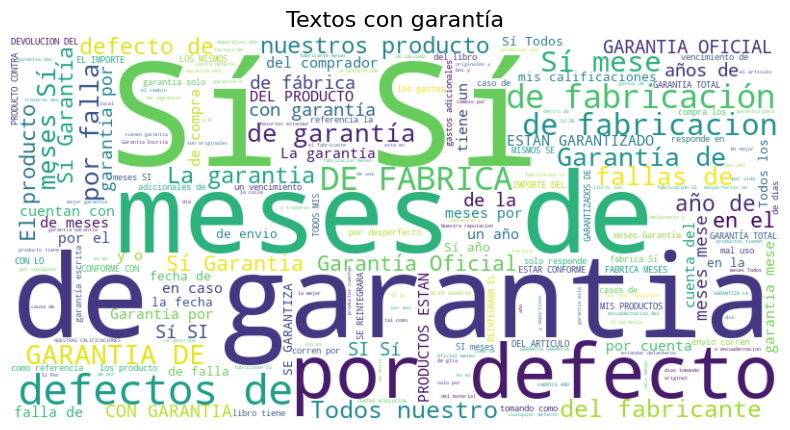

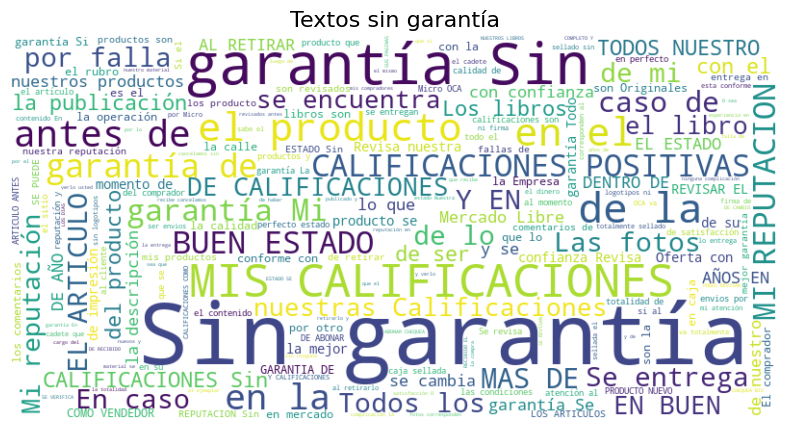

In [74]:
# Se muestra una nubde palabras de los textos de la columna warranty para verificar que la agrupacion es correcta

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Agrupar textos según has_warranty
textos_con = " ".join(X_train.loc[X_train['has_warranty'] == 1.0, 'warranty'].dropna().astype(str))
textos_sin = " ".join(X_train.loc[X_train['has_warranty'] == 0.0, 'warranty'].dropna().astype(str))

# Configuración general
def mostrar_wordcloud(texto, titulo):
    wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=16)
    plt.show()

# Mostrar
mostrar_wordcloud(textos_con, "Textos con garantía")
mostrar_wordcloud(textos_sin, "Textos sin garantía")

In [75]:
X_train.drop(columns=['warranty', 'warranty_cluster', "warranty_label"], inplace=True)

### Tratamiento de columnas fechas y tiempos

In [76]:
# Se crean nuevas columnas para la fecha de creación

X_train['date_created'] = pd.to_datetime(X_train['date_created'], errors='coerce')

X_train['year'] = X_train['date_created'].dt.year
X_train['month'] = X_train['date_created'].dt.month
X_train['day'] = X_train['date_created'].dt.day
X_train['weekday'] = X_train['date_created'].dt.weekday
X_train['is_weekend'] = X_train['weekday'].isin([5, 6]).astype(int)

X_train.drop(columns=['date_created'], inplace=True)

In [77]:
#Se crea una nueva columna para la combinacion de start_time y stop_time

X_train["start_time"] = pd.to_datetime(X_train["start_time"], errors="coerce", unit="ms")
X_train["stop_time"] = pd.to_datetime(X_train["stop_time"], errors="coerce", unit="ms")

# Calcular diferencia en días, evitando errores por valores nulos
X_train["active_period"] = (X_train['stop_time'] - X_train['start_time']).dt.days

# Eliminar columnas originales
X_train.drop(columns=["start_time", "stop_time"], inplace=True)

### Revision final de nulos

In [78]:
# Se elimina parent_item_id por ser un valor con muchos NaN

print(X_train["parent_item_id"].nunique(), X_train["parent_item_id"].isna().sum())
X_train.drop(columns=['parent_item_id'], inplace=True)

# Se eliminan valores que tengan algun NaN
X_train = X_train.dropna(axis=0)

69310 20690


In [79]:
# Revision de valores unicos de las columnas categoricas y ver si se pueden agrupar o simplificar

cols_to_analyze = ["listing_type_id" , "buying_mode", "currency_id", "status", "seller_address.state.name", "seller_address.state.id", "seller_address.city.name", "shipping.mode"]

for i in cols_to_analyze:
    print(f"===== {i} =====")
    print(X_train[i].value_counts())
    print(X_train[i].unique())
    print(X_train[i].nunique())

===== listing_type_id =====
listing_type_id
bronze          56904
free            19259
silver           8195
gold_special     2693
gold             2169
gold_premium      765
gold_pro           13
Name: count, dtype: int64
['bronze' 'silver' 'free' 'gold_special' 'gold' 'gold_premium' 'gold_pro']
7
===== buying_mode =====
buying_mode
buy_it_now    87310
classified     1981
auction         707
Name: count, dtype: int64
['buy_it_now' 'classified' 'auction']
3
===== currency_id =====
currency_id
ARS    89494
USD      504
Name: count, dtype: int64
['ARS' 'USD']
2
===== status =====
status
active            86114
paused             3863
closed               20
not_yet_active        1
Name: count, dtype: int64
['active' 'paused' 'closed' 'not_yet_active']
4
===== seller_address.state.name =====
seller_address.state.name
Capital Federal        52142
Buenos Aires           31482
Santa Fe                2398
Córdoba                 1727
Mendoza                  400
Chubut                   335

In [ ]:
print(X_train["buying_mode"].unique(), X_train["buying_mode"].nunique(), X_train["buying_mode"].value_counts())
print(X_train["currency_id"].unique(), X_train["currency_id"].nunique(), X_train["currency_id"].value_counts())
print(X_train["status"].unique(), X_train["status"].nunique(), X_train["status"].value_counts())
print(X_train["shipping.mode"].unique(), X_train["shipping.mode"].nunique(), X_train["shipping.mode"].value_counts())

In [ ]:
# La columna currency_id tiene 2 valores únicos, por lo que se deja como binario

X_train["Currency_ARS"] = (X_train["currency_id"] == "ARS").astype(int)
X_train.drop(columns=["currency_id"], inplace=True)

# La columna status tiene 4 valores unicos, pero se dejaran solo 2 como relevantes, el resto se agrupan como "other"

X_train["status"] = X_train["status"].apply(lambda x: x if x in ["active", "paused"] else "other")

# La columna shipping.mode tiene 4 valores unicos, pero se dejaran solo 3 como relevantes, el resto se agrupan como "custom"
X_train["shipping.mode"] = X_train["shipping.mode"].replace("me1", "custom")

### Revision de correlaciones numericas

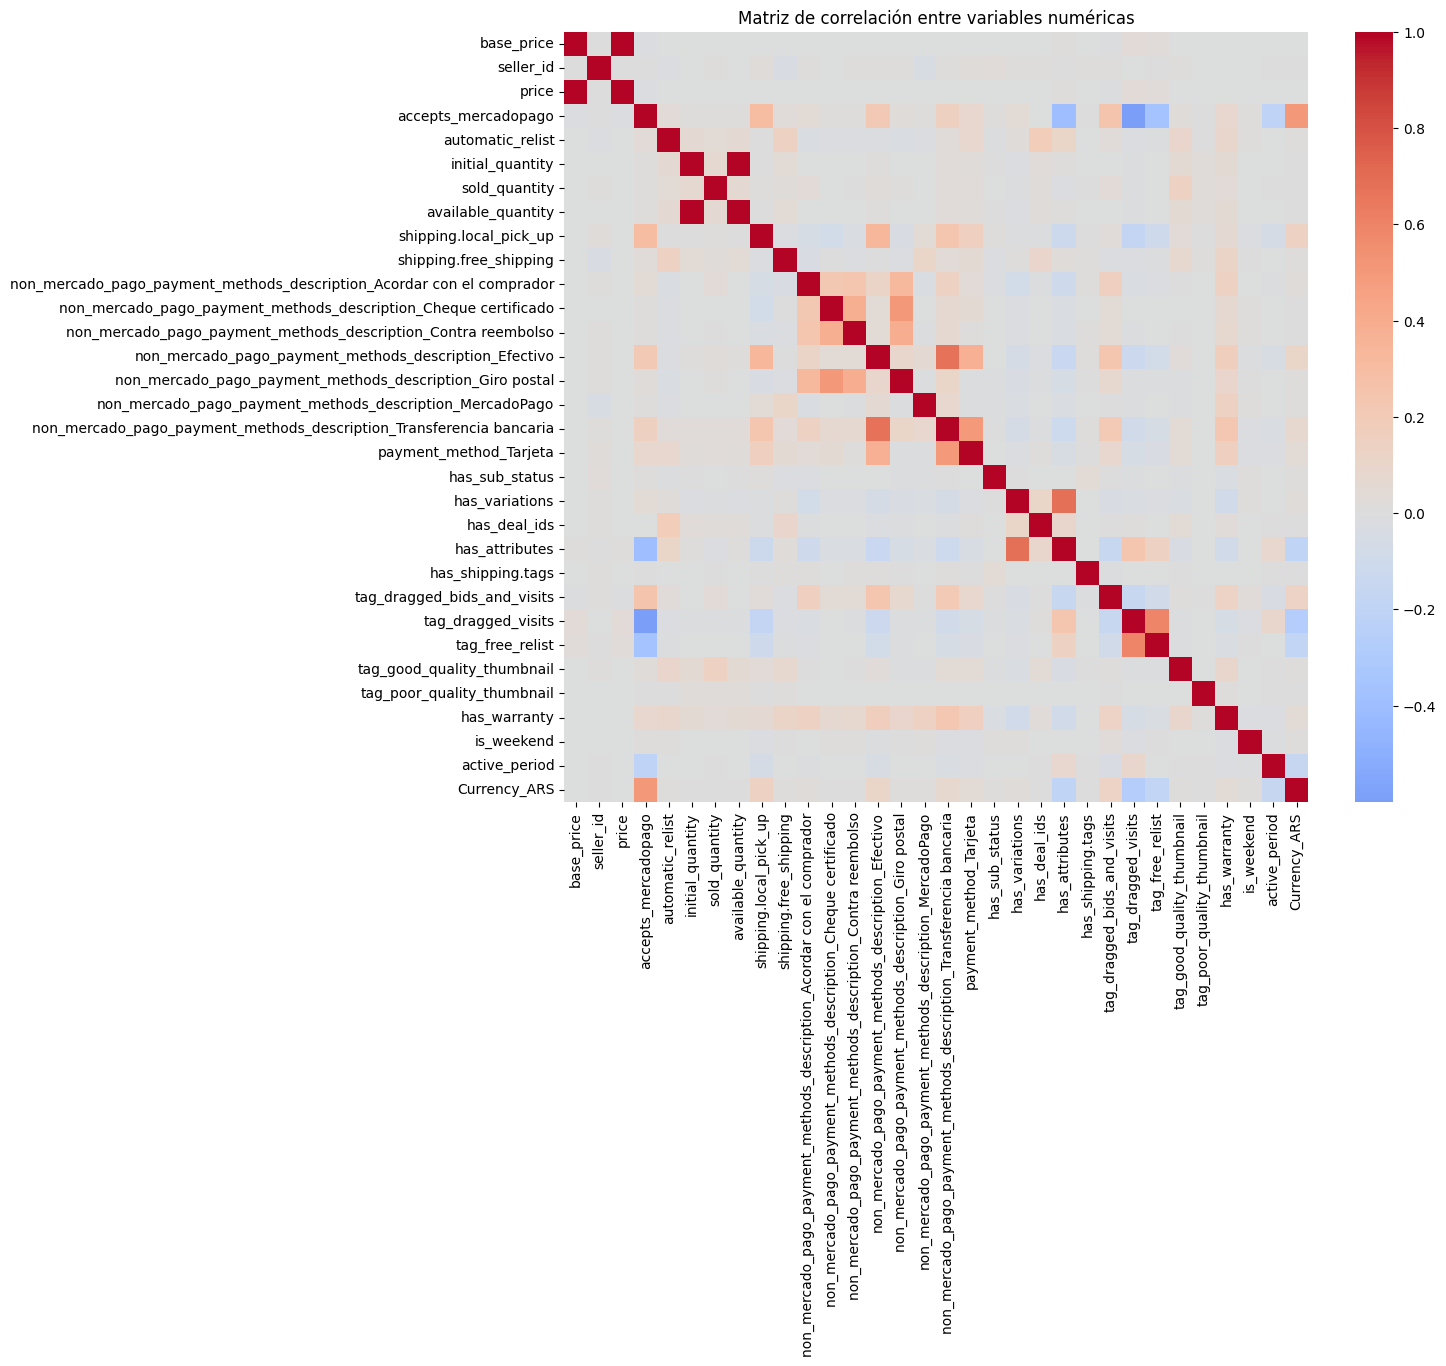

Correlaciones fuertes (> 0.8 o < -0.8):
                    base_price  price  initial_quantity  available_quantity
base_price                 NaN    1.0               NaN                 NaN
price                      1.0    NaN               NaN                 NaN
initial_quantity           NaN    NaN               NaN            0.999944
available_quantity         NaN    NaN          0.999944                 NaN


In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Solo las columnas numéricas
numeric_df = X_train.select_dtypes(include=['int64', 'float64'])

# Calcular matriz de correlación
corr_matrix = numeric_df.corr()

# Graficar matriz
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

threshold = 0.8
high_corr = corr_matrix[(corr_matrix.abs() > threshold) & (corr_matrix != 1.0)]
print("Correlaciones fuertes (> 0.8 o < -0.8):")
print(high_corr.dropna(how='all').dropna(axis=1, how='all'))

In [ ]:
# Se eliminan columnas con alta correlacion
X_train.drop(columns=['base_price', 'initial_quantity'], inplace=True)

### Revision de correlacion entre seller_address.state.id y seller_address.state.name

In [81]:

# Ver cuántos pares únicos existen
num_pairs = X_train[["seller_address.state.id", "seller_address.state.name"]].drop_duplicates().shape[0]

# Ver cuántos valores únicos hay de cada lado
num_ids = X_train["seller_address.state.id"].nunique()
num_names = X_train["seller_address.state.name"].nunique()

print(f"Pares únicos: {num_pairs}, IDs: {num_ids}, Nombres: {num_names}")

# Se elimina seller_address.state.name por ser un valor con correlacion perfecta con seller_address.state.id
X_train.drop(columns=['seller_address.state.id'], inplace=True)

Pares únicos: 24, IDs: 24, Nombres: 24


### Dataframe X_train final

In [85]:
X_train

,condition,base_price,seller_id,listing_type_id,price,buying_mode,category_id,accepts_mercadopago,automatic_relist,status,initial_quantity,sold_quantity,available_quantity,seller_address.state.name,seller_address.city.name,shipping.local_pick_up,shipping.free_shipping,shipping.mode,non_mercado_pago_payment_methods_description_Acordar con el comprador,non_mercado_pago_payment_methods_description_Cheque certificado,non_mercado_pago_payment_methods_description_Contra reembolso,non_mercado_pago_payment_methods_description_Efectivo,non_mercado_pago_payment_methods_description_Giro postal,non_mercado_pago_payment_methods_description_MercadoPago,non_mercado_pago_payment_methods_description_Transferencia bancaria,payment_method_Tarjeta,has_sub_status,has_variations,has_deal_ids,has_attributes,has_shipping.tags,tag_dragged_bids_and_visits,tag_dragged_visits,tag_free_relist,tag_good_quality_thumbnail,tag_poor_quality_thumbnail,has_warranty,year,month,day,weekday,is_weekend,active_period,Currency_ARS
0,new,80.00,8208882349,bronze,80.00,buy_it_now,MLA126406,1.0,0.0,active,1,0,1,Capital Federal,San Cristóbal,1.0,0.0,not_specified,1,0,0,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0.0,2015,9,5,5,1,60,1
1,used,2650.00,8141699488,silver,2650.00,buy_it_now,MLA10267,1.0,0.0,active,1,0,1,Capital Federal,Buenos Aires,1.0,0.0,me2,0,0,0,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,2015,9,26,5,1,60,1
2,used,60.00,8386096505,bronze,60.00,buy_it_now,MLA1227,1.0,0.0,active,1,0,1,Capital Federal,Boedo,1.0,0.0,me2,0,0,0,1,0,0,1,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0.0,2015,9,9,2,0,60,1
3,new,580.00,5377752182,silver,580.00,buy_it_now,MLA86345,1.0,0.0,active,1,0,1,Capital Federal,Floresta,1.0,0.0,me2,0,0,0,1,0,0,1,1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,2015,9,28,0,0,66,1
4,used,30.00,2938071313,bronze,30.00,buy_it_now,MLA41287,1.0,0.0,active,1,0,1,Buenos Aires,Tres de febrero,1.0,0.0,not_specified,1,0,0,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0.0,2015,8,24,0,0,60,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,used,68.00,9451922715,bronze,68.00,buy_it_now,MLA1227,1.0,0.0,active,1,0,1,Capital Federal,capital federal,0.0,0.0,me2,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0.0,2015,10,2,4,0,60,1
89996,new,126.00,4665194056,bronze,126.00,buy_it_now,MLA45559,1.0,0.0,paused,1,1,1,Capital Federal,Núñez,1.0,0.0,custom,0,0,0,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0.0,2015,9,22,1,0,60,1
89997,new,300.00,3046474001,bronze,300.00,buy_it_now,MLA81061,1.0,0.0,active,1,0,1,Buenos Aires,La Matanza,1.0,0.0,not_specified,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0.0,2015,8,24,0,0,60,1
89998,new,696.58,2373910598,bronze,696.58,buy_it_now,MLA48851,1.0,0.0,active,100,0,100,Chubut,Trelew,0.0,0.0,not_specified,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1.0,2015,10,2,4,0,60,1
